# 🛑 Spam Email Detector

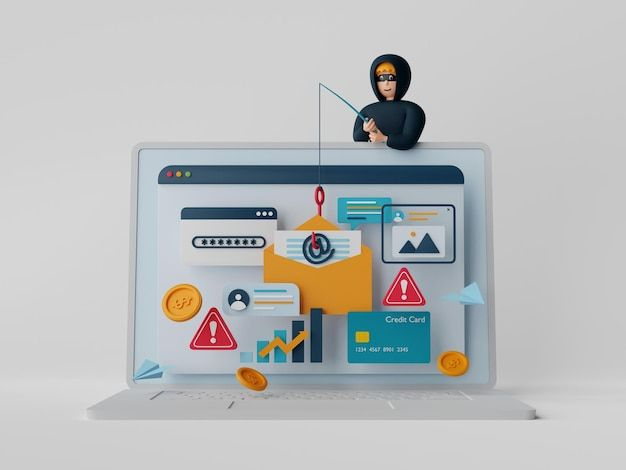


---

## Problem Understanding and Data Exploration

### 1. Problem Definition
Spam emails are one of the most common online issues.
They often contain scams, phishing links, or unwanted advertisements that can put users at risk.

The main problem is to automatically detect and classify emails as spam or not spam (ham) based on their text content.
This helps reduce user exposure to unsafe or irrelevant messages.


### 2. Scope

- Focuses on **text data** only (no images or attachments).  
- Initially handles **English-language messages**.  
- Provides **real-time or batch classification** of messages.  

### 3. Team Role Distribution — Phase 1

| Member | Role | Responsibilities |
|---------|------|------------------|
|  [fajr alkatheri] | **Data Cleaning & Handling Missing Values** | Checked, filled, and standardized missing data. Ensured dataset consistency and exported cleaned version. |
| [renad] | **Feature Extraction** | Analyzed columns, decided which features to keep/drop, and created new features |
| [rahaf & rawan] | **Text Preprocessing** | Cleaned email body (remove HTML tags, symbols), applied tokenization, normalized casing. |
| [salha] | **Text Representation (Vectorization)** | Researched and implemented different text representation methods (TF-IDF, CountVectorizer). |


### 4. Dataset Overview

**Data Source Options:**  
- [Phishing Email Dataset](https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset)  

**Data Columns:**  
- `sender`: Email or phone number of the message sender  
- `receiver`: Recipient email or phone number  
- `date`: Timestamp of the message  
- `subject`: Subject line of the message  
- `body`: Main content of the message (text)  
- `label`: `if its spam 1` or `0` (number)  
- `urls`: `if it contains a URL 1` or `0` (number)  
 

### 5. Project Objective  
This project aims to create a system that can automatically classifies incoming text messages or emails as **spam** or **not spam (ham)**.   
It helps users know which messages are safe to open and which ones might be unwanted or risky.  

Specifically, it will:  
- Analyze the content of emails or SMS messages.  
- Label messages as spam or ham.  
- Help protect users from scams, phishing, and unwanted advertisements.  

It works as a **binary classification model** that uses **text data** to make its predictions.  


---






### Step 1:First lets Load the data

In [1]:
import pandas as pd

In [2]:
df=pd.read_csv("CEAS_08.csv")
df.head()
#if lable 1 its a scamming email if 0 no

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


In [3]:
len(df)

39154

In [4]:
print("detailed:", df.shape, df['label'].value_counts())

detailed: (39154, 7) label
1    21842
0    17312
Name: count, dtype: int64


**Summary:**  
The dataset contains **39,154 rows and 7 columns**.  
It includes **21,842 spam (1)** and **17,312 ham (0)** messages, showing a relatively balanced distribution between the two classes.



---

### Step 2: Exploring the Dataset  

Quick look at the data to check size and class balance before cleaning.

In [5]:
# Shape + label balance 
print("Shape:", df.shape)
label_counts = df["label"].value_counts().sort_index()  # 0, 1
print("Label counts:\n", label_counts)

Shape: (39154, 7)
Label counts:
 label
0    17312
1    21842
Name: count, dtype: int64



**Summary:**  
The dataset contains **39,154 rows** and **7 columns**.  
There are slightly more spam emails (label 1) than ham emails (label 0), but the classes are fairly balanced overall.  

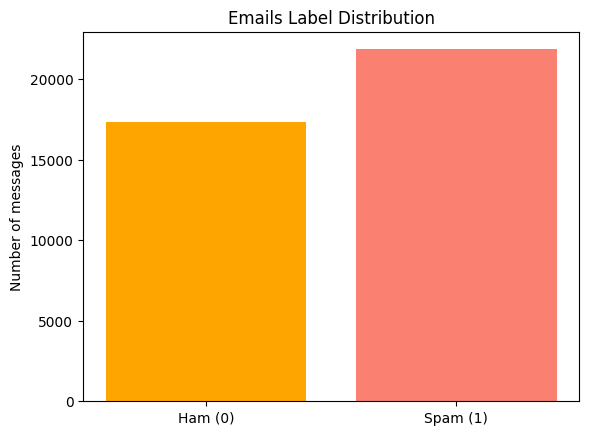

In [6]:
# Bar chart: label distribution (from the data)
import matplotlib.pyplot as plt

labels = ["Ham (0)", "Spam (1)"]
counts = label_counts.reindex([0, 1], fill_value=0).values

plt.bar(labels, counts, color=['orange', 'salmon'])  
plt.title("Emails Label Distribution")
plt.ylabel("Number of messages")
plt.show()

**Summary:**  
The two classes are reasonably close in size, which is good for training, but keep the slight imbalance in mind.

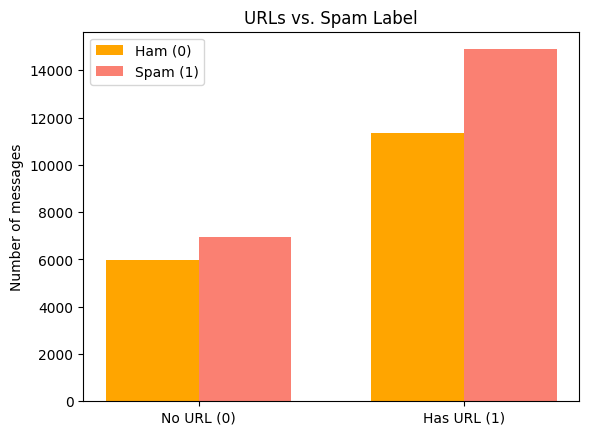

In [7]:
# Explore if URLs affect spam likelihood 
import matplotlib.pyplot as plt

url_table = (
    df.groupby(["urls", "label"])
      .size()
      .unstack(fill_value=0)
      .reindex(index=[0, 1], fill_value=0)
)

x = [0, 1]  # 0 = no URL, 1 = has URL
ham = url_table.get(0, [0, 0]).values
spam = url_table.get(1, [0, 0]).values

width = 0.35
plt.figure()
plt.bar([i - width/2 for i in x], ham, width, color='orange', label="Ham (0)")
plt.bar([i + width/2 for i in x], spam, width, color='salmon', label="Spam (1)")
plt.xticks(x, ["No URL (0)", "Has URL (1)"])
plt.title("URLs vs. Spam Label")
plt.ylabel("Number of messages")
plt.legend()
plt.show()

**Summary:**  
This chart shows how the presence of URLs in an email relates to whether it’s spam or not.  
We noticed that most spam emails contain URLs, which makes sense since phishing and scam messages often include links.  

---

### Step 3: Data Cleaning and Handling Missing Values 

In this step, we cleaned the dataset to make sure it’s complete and consistent before moving forward.  
We mainly focused on handling missing values, fixing data types, and ensuring that important columns don’t contain empty or invalid data.


In [8]:
# We’ll use a helper function (missing_report) to display the missing count and percentage clearly.

def missing_report(frame):
    mc = frame.isna().sum()
    mp = (frame.isna().mean() * 100).round(2)
    rep = (
        pd.concat([mc.rename("Missing Count"), mp.rename("Missing %")], axis=1)
        .sort_values("Missing %", ascending=False)
    )
    return rep

missing_before = missing_report(df)
missing_before


,Missing Count,Missing %
receiver,462,1.18
subject,28,0.07
sender,0,0.00
date,0,0.00
body,0,0.00
label,0,0.00
urls,0,0.00


**Observation:**  
We found a small percentage of missing data:
- `receiver` column has around **1.18%** missing values.  
- `subject` column has around **0.07%** missing values.  
- All other columns are complete (`body`, `label`, `urls`, `date`, and `sender`).  

**Handling Missing Values Code:**

In [9]:
# Handle missing values carefully
# receiver: replace missing with empty string ("") to avoid bias
# subject: replace missing with "No Subject" since many real emails have no subject

df['receiver'] = df['receiver'].fillna("")
df['subject'] = df['subject'].fillna("No Subject")

# Verify again
missing_after = missing_report(df)
missing_after


,Missing Count,Missing %
sender,0,0.0
receiver,0,0.0
date,0,0.0
subject,0,0.0
body,0,0.0
label,0,0.0
urls,0,0.0


**Explanation**

For the `receiver` column, we decided to fill missing values with an empty string (`""`) instead of a fake email.  
We first considered adding a placeholder such as `"unknown@gvc.ceas-challenge.cc"`,  
but we realized this could make the model learn a false pattern. 

For the subject column, we replaced missing values with "No Subject" since some real emails don’t have a subject line.


**checking data types** :

In [10]:
# Inspect dtypes before fixing
print("Dtypes BEFORE:\n", df.dtypes, "\n")

# Quick peek at unique values for binary columns (if present)
for col in ["label", "urls"]:
    if col in df.columns:
        print(f"Unique values in `{col}` (sample):", df[col].dropna().unique()[:10])


Dtypes BEFORE:
 sender      object
receiver    object
date        object
subject     object
body        object
label        int64
urls         int64
dtype: object 

Unique values in `label` (sample): [1 0]
Unique values in `urls` (sample): [1 0]


**Summary:**  
We checked the data types of all columns to make sure they were correctly recognized.  
Both `label` and `urls` columns contained only 0 and 1 values, which confirms they are properly encoded as binary features.  

**Cleaning Text Columns** :

In [11]:
# Clean and standardize text columns
text_cols = [c for c in ["sender", "receiver", "subject", "body"] if c in df.columns]

for col in text_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.strip()                # remove leading/trailing spaces
        .str.replace(r"\s+", " ", regex=True)  # collapse multiple spaces
    )

print("✅ Text fields cleaned (trimmed and normalized).")


✅ Text fields cleaned (trimmed and normalized).


**Result:**  
All text-based columns (`sender`, `receiver`, `subject`, `body`) were converted to clean, uniform strings.  
Extra whitespace was removed, and spacing was normalized.  
This ensures the text is ready for NLP preprocessing in the next phase.


**final verification after cleaning** :

In [12]:
# 1) No missing values anywhere
missing_after = df.isna().sum().sort_values(ascending=False)
print("Missing values per column (AFTER):\n", missing_after, "\n")
assert missing_after.sum() == 0, "There are still missing values. Please review."

# 2) Dtypes look sensible
print("Dtypes AFTER:\n", df.dtypes, "\n")

# 3) Binary columns contain only 0/1
for col in ["label", "urls"]:
    if col in df.columns:
        uniq = sorted(df[col].unique().tolist())
        print(f"Unique values in `{col}`:", uniq)
        assert set(uniq).issubset({0, 1}), f"{col} must be binary 0/1."

# 4) Quick sanity on text: show a few cleaned samples
display(df.sample(5, random_state=7)[["sender","receiver","subject","body","label","urls"]])


Missing values per column (AFTER):
 sender      0
receiver    0
date        0
subject     0
body        0
label       0
urls        0
dtype: int64 

Dtypes AFTER:
 sender      object
receiver    object
date        object
subject     object
body        object
label        int64
urls         int64
dtype: object 

Unique values in `label`: [0, 1]
Unique values in `urls`: [0, 1]


,sender,receiver,subject,body,label,urls
7775,John McCreesh <ygpeu@openoffice.org>,askfvcva@openoffice.org,[ooo-announce] The OpenOffice.org Annual Confe...,Members of the OpenOffice.org Community have s...,0,1
9293,Tim Golden <cggc@timgolden.me.uk>,,"Re: [python-win32] win32gui.EnumWindows, docum...","Julius wrote: > Hi, > > im new to python in ge...",0,1
25284,Doreen Pool <dwtebulm@tebul.fi>,user2.4@gvc.ceas-challenge.cc,From Doreen Pool,B mz u haf y From On myd line P qzy har yg ma ...,1,1
36276,CNN Alerts <muonadat_1969@frlaw.com>,user7-ext5@gvc.ceas-challenge.cc,CNN Alerts: My Custom Alert,CNN Alerts: My Custom Alert Alert Name: My Cus...,1,0
14211,mouss <qpeqr@netoyen.net>,Juan Miscaro <obao_fb@yahoo.ca>,Re: maidrop error: Unable to open mailbox (why?),Juan Miscaro wrote: > --- mouss wrote: > > > >...,0,0


**Validation Summary**
- No missing values remain across all columns.
- `label` and `urls` are strictly binary (0/1).
- Text fields are trimmed and normalized (no odd spacing).



---
### Step 4: Feature Extraction (Renad)

In [13]:
df['sender'].value_counts()

sender
qydlqcws-iacfym@issues.apache.org                      462
Guido van Rossum <hoauf@python.org>                    295
"\\"Martin v. Löwis\\"" <qpnysl@v.loewis.de>           276
"Carlos E. R." <vyjwd.trpcau@telefonica.net>           208
Aaron Kulkis <cmiqlkx91@hotpop.com>                    183
                                                      ... 
Daily Top 10 <Scooter-obailat@picklesmaternity.com>      1
Alphonso Roach <exited@realskate.com>                    1
Racing <uqyrmo@sailing.ie>                               1
Daily Top 10 <Joep-ntorions@picklesmaternity.com>        1
Daily Top 10 <Marci-ntelstok@picklesmaternity.com>       1
Name: count, Length: 24578, dtype: int64

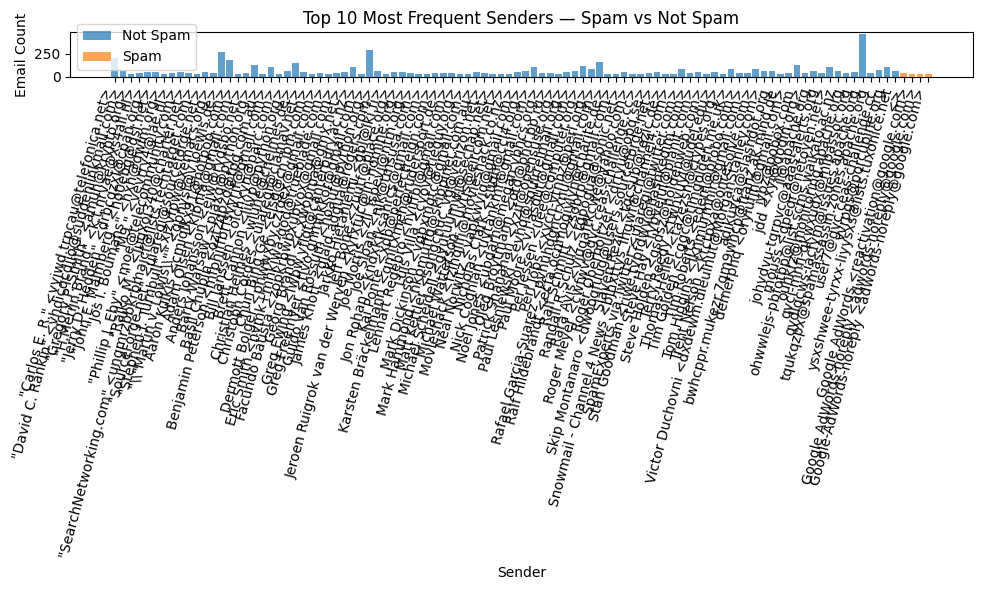

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# visulizing if the sender column is an indicator of a spam email or not
sender_counts = (
    df.groupby(['sender', 'label'])
    .size()
    .reset_index(name='count')
)


top_senders = (
    sender_counts.groupby('sender')['count'].sum()
    .sort_values(ascending=False)
    .head(100)
    .index
)


top_data = sender_counts[sender_counts['sender'].isin(top_senders)]


plt.figure(figsize=(10,6))
for label_value, label_name in [(0, "Not Spam"), (1, "Spam")]:
    subset = top_data[top_data['label'] == label_value]
    plt.bar(
        subset['sender'],
        subset['count'],
        label=label_name,
        alpha=0.7
    )

plt.title("Top 10 Most Frequent Senders — Spam vs Not Spam")
plt.xlabel("Sender")
plt.ylabel("Email Count")
plt.xticks(rotation=75, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


### Sender and Receiver Insights

1. **Sender Email**  
   - Apparently, the sender email **isn’t a strong indicator** of spam.  
   - Will **drop this column**.

2. **Receiver Behavior**  
   - Checking if a receiver **gets more spam than the rest** could be an indicator.  
   - This might reveal if a person is **irresponsible with their email** and exposes it widely.


In [15]:
# 1. Count total and spam per receiver
receiver_stats = (
    df.groupby('receiver')['label']
      .agg(receiver_total_emails='count',
           receiver_spam_count='sum') #counting if spam increments 1 and if ham its just Zero nothing changes
      .reset_index()
)

# 2. Compute spam ratio
receiver_stats['receiver_spam_ratio'] = (
    receiver_stats['receiver_spam_count'] / receiver_stats['receiver_total_emails']
)


df = df.merge(receiver_stats, on='receiver', how='left')
df.head()

,sender,receiver,date,subject,body,label,urls,receiver_total_emails,receiver_spam_count,receiver_spam_ratio
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,424,424,1.000000
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...,1,1,922,894,0.969631
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,379,378,0.997361
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,3,0,0.000000
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iwf...,1,1,922,894,0.969631


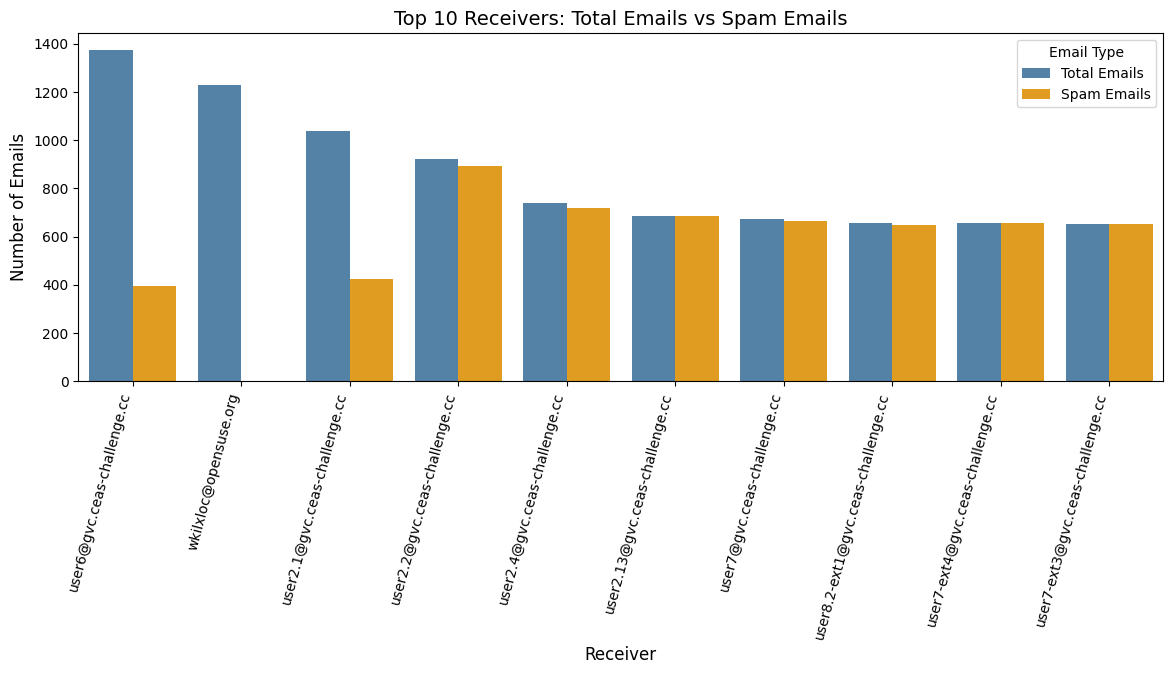

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pick top 10 receivers by total emails: they recived most emails
top_receivers = df[['receiver', 'receiver_total_emails', 'receiver_spam_count']].drop_duplicates()
top_receivers = top_receivers.sort_values('receiver_total_emails', ascending=False).head(10)

# Melt the dataframe for seaborn
plot_data = top_receivers.melt(
    id_vars='receiver', 
    value_vars=['receiver_total_emails', 'receiver_spam_count'],
    var_name='Email Type', 
    value_name='Count'
)

# Rename for clear legend
plot_data['Email Type'] = plot_data['Email Type'].replace({
    'receiver_total_emails': 'Total Emails',
    'receiver_spam_count': 'Spam Emails'
})

# Plot with custom colors
plt.figure(figsize=(14,6))
sns.barplot(
    data=plot_data, 
    x='receiver', 
    y='Count', 
    hue='Email Type',
    palette={'Total Emails': 'steelblue', 'Spam Emails': 'orange'}
)
plt.xticks(rotation=75, ha='right')
plt.title("Top 10 Receivers: Total Emails vs Spam Emails", fontsize=14)
plt.xlabel("Receiver", fontsize=12)
plt.ylabel("Number of Emails", fontsize=12)
plt.legend(title='Email Type')
plt.subplots_adjust(bottom=0.3)  # ensures rotated labels fit
plt.show()


## Receiver-Based Features

- **receiver_total_emails**  
  - By itself, this is **not very predictive**.  
  - Mostly measures the **activity of the receiver**, not spam likelihood.

- **receiver_spam_count**  
  - Also **not ideal alone**.  
  - Counts past spam, but for unseen emails, the model **won’t know future spam counts**.

- **Better Feature: receiver_spam_ratio**  
  - Calculated as `spam / total` emails.  
  - **Normalizes spam by total emails** for each receiver.  
  - Captures whether a receiver is **“spam-heavy” relative to their total emails**.  
  - This is the feature that can **help the model learn patterns**.

### Action
- **Drop** `receiver_total_emails` and `receiver_spam_count`.  
- **Keep** `receiver_spam_ratio`.


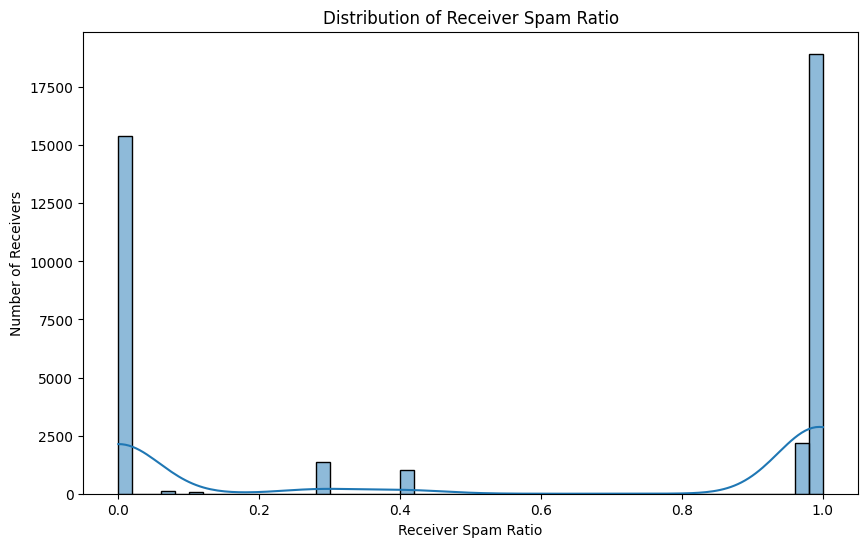

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.histplot(df['receiver_spam_ratio'], bins=50, kde=True)
plt.title('Distribution of Receiver Spam Ratio')
plt.xlabel('Receiver Spam Ratio')
plt.ylabel('Number of Receivers')
plt.show()


## Spam Ratio Feature
- The `receiver_spam_ratio` feature revealed **clusters of receivers**, suggesting that this ratio is a **good indicator of spam**.

### Extracting Features from the Date Column
- The raw **date itself isn’t a clear indicator** of spam.  
- However, certain **hours may show patterns** for spam across the dataset.  
- Let’s explore if spam emails tend to occur at **common hours**.


| Feature                                    | Why useful for spam                                |
| ------------------------------------------ | -------------------------------------------------- |
| **Hour of the day**                        | Spam may be more frequent at certain hours         |
| **Day of week** (`Tuesday`)                | Some spam campaigns target weekdays vs weekends    |
| **Is weekend** (True/False)                | Quick binary check for weekend vs weekday patterns |
| **Month or season**                        | Some spam spikes in holidays or certain months     |


In [18]:
import pandas as pd

# 1: Convert to datetime, handle errors and mixed timezones
df['date_clean'] = pd.to_datetime(df['date'], errors='coerce', utc=True) #it has a time zone

# 2: Drop rows that couldn't be parsed
df = df.dropna(subset=['date_clean'])

# 3: Extract features
df['hour'] = df['date_clean'].dt.hour
df['day_of_week'] = df['date_clean'].dt.day_name()
df['is_weekend'] = df['date_clean'].dt.weekday >= 5  # True if Saturday/Sunday USA weekends

print(df[['date', 'date_clean', 'hour', 'day_of_week', 'is_weekend']].head())


                              date                date_clean  hour  \
0  Tue, 05 Aug 2008 16:31:02 -0700 2008-08-05 23:31:02+00:00    23   
1  Tue, 05 Aug 2008 18:31:03 -0500 2008-08-05 23:31:03+00:00    23   
2  Tue, 05 Aug 2008 20:28:00 -1200 2008-08-06 08:28:00+00:00     8   
3  Tue, 05 Aug 2008 17:31:20 -0600 2008-08-05 23:31:20+00:00    23   
4  Tue, 05 Aug 2008 19:31:21 -0400 2008-08-05 23:31:21+00:00    23   

  day_of_week  is_weekend  
0     Tuesday       False  
1     Tuesday       False  
2   Wednesday       False  
3     Tuesday       False  
4     Tuesday       False  


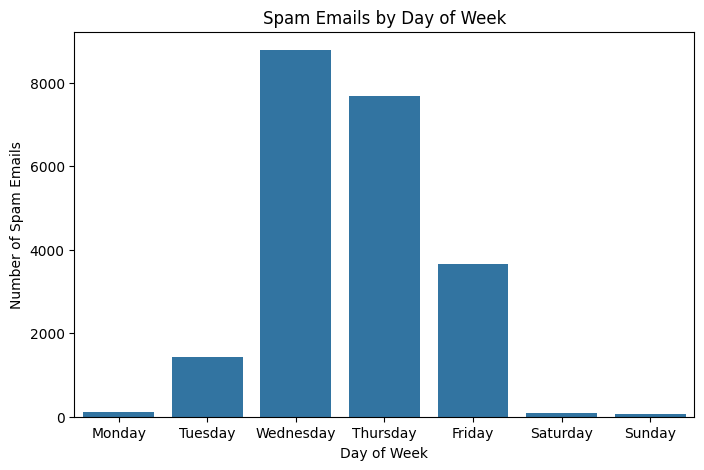

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only spam emails
spam_df = df[df['label'] == 1]

# Count by day of week
plt.figure(figsize=(8,5))
sns.countplot(x='day_of_week', data=spam_df,
              order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
plt.title('Spam Emails by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Spam Emails')
plt.show()


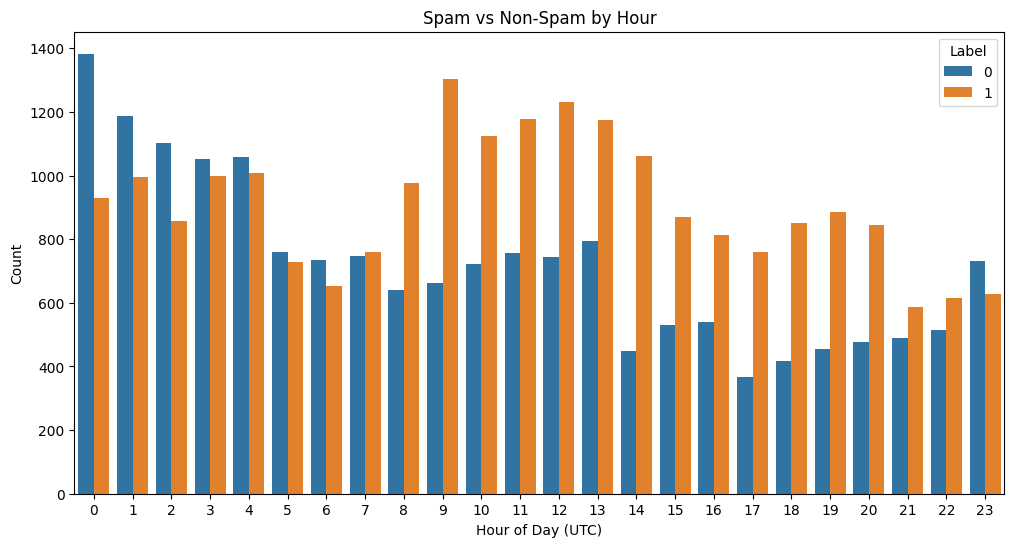

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.countplot(x='hour', hue='label', data=df)
plt.title('Spam vs Non-Spam by Hour')
plt.xlabel('Hour of Day (UTC)')
plt.ylabel('Count')
plt.legend(title='Label', loc='upper right')
plt.show()


In [21]:
print("Spam count by hour:")
print(df[df['label']==1]['hour'].value_counts().sort_index())

print("\nSpam count by day_of_week:")
print(df[df['label']==1]['day_of_week'].value_counts().reindex(
      ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']))


Spam count by hour:
hour
0      930
1      994
2      856
3      998
4     1007
5      727
6      653
7      759
8      977
9     1303
10    1125
11    1178
12    1230
13    1174
14    1063
15     869
16     813
17     761
18     852
19     886
20     844
21     586
22     614
23     628
Name: count, dtype: int64

Spam count by day_of_week:
day_of_week
Monday        111
Tuesday      1441
Wednesday    8785
Thursday     7689
Friday       3662
Saturday       82
Sunday         57
Name: count, dtype: int64


# Observations

### Hour
- Spam is higher roughly between **9–14 (UTC)**, showing a clear **cluster of high activity**.  
- This will be **used as a feature**.

### Day of Week
- Most spam occurs on **Wednesday–Thursday**, some on **Tuesday**, and almost none on the **weekend**.  
- This will also be **used as a feature**.


In [22]:
df.head()

,sender,receiver,date,subject,body,label,urls,receiver_total_emails,receiver_spam_count,receiver_spam_ratio,date_clean,hour,day_of_week,is_weekend
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,424,424,1.000000,2008-08-05 23:31:02+00:00,23,Tuesday,False
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...,1,1,922,894,0.969631,2008-08-05 23:31:03+00:00,23,Tuesday,False
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,379,378,0.997361,2008-08-06 08:28:00+00:00,8,Wednesday,False
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,3,0,0.000000,2008-08-05 23:31:20+00:00,23,Tuesday,False
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iwf...,1,1,922,894,0.969631,2008-08-05 23:31:21+00:00,23,Tuesday,False


In [23]:
cols_to_drop = ['sender', 'receiver','date', 'receiver_total_emails','receiver_spam_count','date_clean','is_weekend']
df.drop(cols_to_drop, axis=1, inplace=True)


In [24]:
df.head()

,subject,body,label,urls,receiver_spam_ratio,hour,day_of_week
0,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,1.000000,23,Tuesday
1,Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...,1,1,0.969631,23,Tuesday
2,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,0.997361,8,Wednesday
3,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,0.000000,23,Tuesday
4,SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iwf...,1,1,0.969631,23,Tuesday


In [25]:
df.isna().sum()

subject                0
body                   0
label                  0
urls                   0
receiver_spam_ratio    0
hour                   0
day_of_week            0
dtype: int64

In [26]:
# Combine texts as they both follow the same pre-process and it is a practice to do so
df['combined_text'] = df['subject'].fillna('') + ' ' + df['body'].fillna('')

# Count uppercase letters,spammers tend to abuse uppercase writing
df['capital_letter_count'] = df['combined_text'].apply(lambda x: sum(1 for c in x if c.isupper()))

# Capital letters ratio
df['capital_ratio'] = df['combined_text'].apply(lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1))  # +1 avoids division by zero

# exclamation and question marks
df['exclamation_count'] = df['combined_text'].apply(lambda x: x.count('!'))
df['question_count'] = df['combined_text'].apply(lambda x: x.count('?'))

# Count other "rare" special characters spammers tend to use as well
spammy_chars = "@#$%^&*()_+=[]{}|\\<>~"
df['special_char_count'] = df['combined_text'].apply(lambda x: sum(1 for c in x if c in spammy_chars))



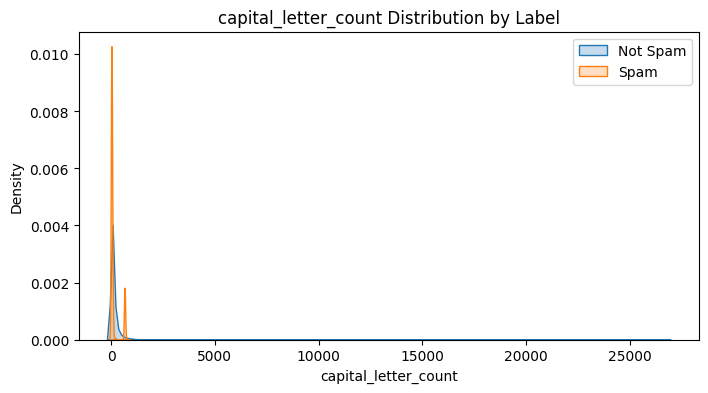

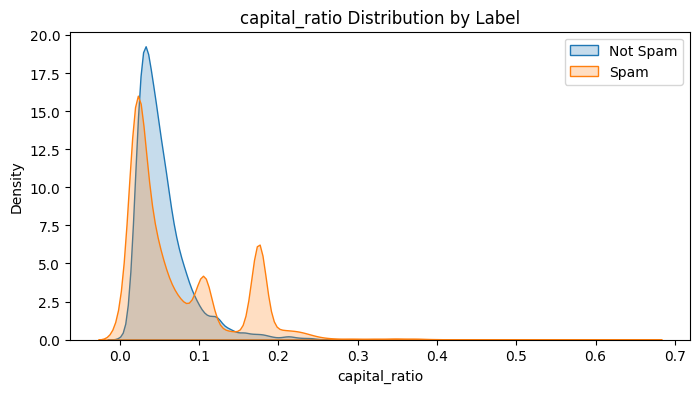

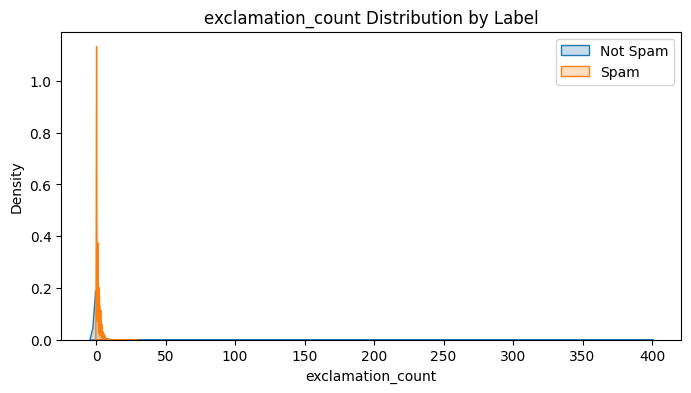

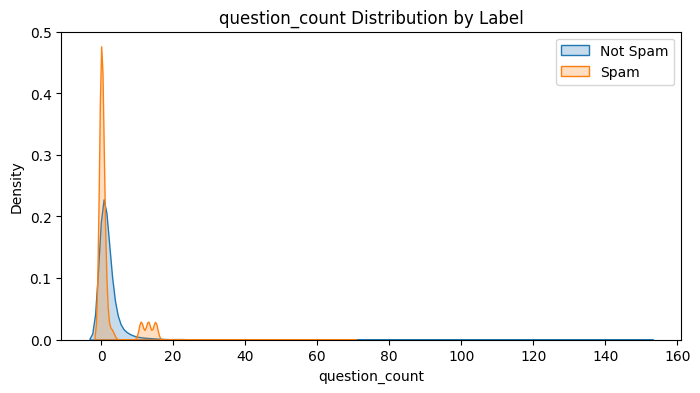

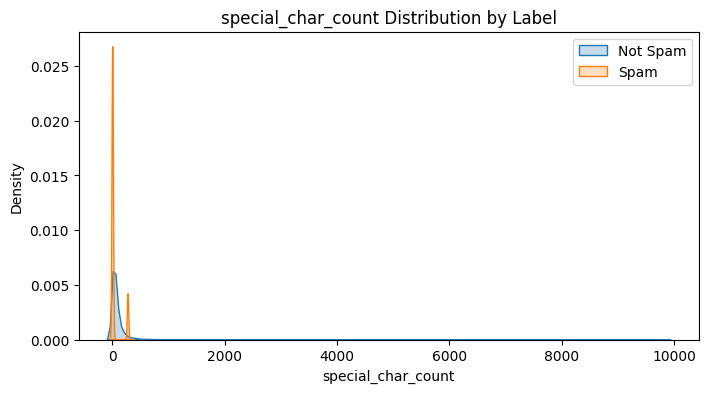

In [27]:
# checking if my assumptions are accurate?
text_features = ['capital_letter_count', 'capital_ratio', 
                 'exclamation_count', 'question_count', 'special_char_count']

for feature in text_features:
    plt.figure(figsize=(8,4))
    sns.kdeplot(df[df['label']==0][feature], label='Not Spam', fill=True)
    sns.kdeplot(df[df['label']==1][feature], label='Spam', fill=True)
    plt.title(f'{feature} Distribution by Label')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


### Observations

- **capital_letter_count, exclamation_count, question_count, special_char_count**  
  - Show **clear spikes for spam**, confirming our assumptions.  
  - These are **strong predictive features** for spam detection.

- **capital_ratio**  
  - Had **higher values for non-spam** emails.  
  - Serves as an **indicator of normal writing style**, complementing other features.


In [28]:
df.head()

,subject,body,label,urls,receiver_spam_ratio,hour,day_of_week,combined_text,capital_letter_count,capital_ratio,exclamation_count,question_count,special_char_count
0,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,1.000000,23,Tuesday,"Never agree to be a loser Buck up, your troubl...",7,0.023490,2,0,0
1,Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...,1,1,0.969631,23,Tuesday,Befriend Jenna Jameson Upgrade your sex and pl...,4,0.039216,0,0,0
2,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,0.997361,8,Wednesday,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,650,0.176009,0,15,273
3,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,0.000000,23,Tuesday,Re: svn commit: r619753 - in /spamassassin/tru...,197,0.008091,4,75,2616
4,SpecialPricesPharmMoreinfo,WelcomeFastShippingCustomerSupport http://7iwf...,1,1,0.969631,23,Tuesday,SpecialPricesPharmMoreinfo WelcomeFastShipping...,40,0.201005,0,0,2


In [29]:
df.drop(['subject', 'body'], axis=1, inplace=True)
#as we combined text

In [30]:
df.head()

,label,urls,receiver_spam_ratio,hour,day_of_week,combined_text,capital_letter_count,capital_ratio,exclamation_count,question_count,special_char_count
0,1,1,1.000000,23,Tuesday,"Never agree to be a loser Buck up, your troubl...",7,0.023490,2,0,0
1,1,1,0.969631,23,Tuesday,Befriend Jenna Jameson Upgrade your sex and pl...,4,0.039216,0,0,0
2,1,1,0.997361,8,Wednesday,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,650,0.176009,0,15,273
3,0,1,0.000000,23,Tuesday,Re: svn commit: r619753 - in /spamassassin/tru...,197,0.008091,4,75,2616
4,1,1,0.969631,23,Tuesday,SpecialPricesPharmMoreinfo WelcomeFastShipping...,40,0.201005,0,0,2


In [31]:
df = pd.get_dummies(df, columns=['day_of_week'], dtype=int)


In [32]:
df.head()

,label,urls,receiver_spam_ratio,hour,combined_text,capital_letter_count,capital_ratio,exclamation_count,question_count,special_char_count,day_of_week_Friday,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,1,1,1.000000,23,"Never agree to be a loser Buck up, your troubl...",7,0.023490,2,0,0,0,0,0,0,0,1,0
1,1,1,0.969631,23,Befriend Jenna Jameson Upgrade your sex and pl...,4,0.039216,0,0,0,0,0,0,0,0,1,0
2,1,1,0.997361,8,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,650,0.176009,0,15,273,0,0,0,0,0,0,1
3,0,1,0.000000,23,Re: svn commit: r619753 - in /spamassassin/tru...,197,0.008091,4,75,2616,0,0,0,0,0,1,0
4,1,1,0.969631,23,SpecialPricesPharmMoreinfo WelcomeFastShipping...,40,0.201005,0,0,2,0,0,0,0,0,1,0


### Summary of Text and Metadata Feature Extraction

- I extracted **commonly used spam-indicative features** based on assumptions about spammers’ behavior.
- Checked our dataset to see if these patterns existed — **the visuals confirmed the assumptions**.
- Combined the **subject** and **body** into a single `combined_text` column, so we can preprocess all text at once (same NLP steps and feature extraction).
- Extracted **text-based features**:
  - `capital_letter_count` → number of uppercase letters
  - `capital_ratio` → proportion of uppercase letters relative to text length
  - `exclamation_count` → number of `!` marks
  - `question_count` → number of `?` marks
  - `special_char_count` → number of rare/suspicious symbols

**Final columns to move forward with for modeling:**

| Column Name                | Description |
|----------------------------|-------------|
| label                      | Target variable (spam or not spam) |
| urls                       | Number of URLs in the email |
| receiver_spam_ratio        | Receiver spam ratio (spam emails / total emails) |
| hour                       | Hour of email sending |
| day_of_week_DayName        | Day of week email was sent encoded  |
| combined_text              | Combined text of subject and body |
| capital_letter_count       | Number of uppercase letters |
| capital_ratio              | Ratio of uppercase letters to text length |
| exclamation_count          | Number of exclamation marks `!` |
| question_count             | Number of question marks `?` |
| special_char_count         | Count of rare/suspicious special characters |


---

### Step 5: Text Preprocessing(Rahaf & Rawan) Look at my notes

random samples 

In [33]:
# Import the pandas library if not already imported
import pandas as pd

# Display 6 random samples from the combined_text column
sample_texts = df['combined_text'].sample(6)

# Show each sample
for i, text in enumerate(sample_texts, 1):
    print(f"--- Sample {i} ---")
    print(text)
    print("\n")


--- Sample 1 ---
Re: [Python-3000] range() issues Alexander Belopolsky wrote: > Facundo Batista gmail.com> writes: >> Ahá! So, as ints are unbound in Python, I could easily do: >> >>>>> r = range(1,1000000000000000000000) > > The problem with supporting this is that len(r) will raise overflow error. > It would be nice to get rid of the limitation on len(), but it will be hard > and may not be possible to do efficiently. My personal preference is that we stay within the bounds of what was possible with the 2.x range() that returned a list instead of a customised object: start, stop and step are unbounded, but the overall length of the resulting sequence cannot exceed sys.maxsize. All that needs to be done to make this consistent is to move the length calculation into the range object's constructor (and Alexander has already provided a patch to do this in issue 2690) Cheers, Nick. -- Nick Coghlan | ncoghlan@gmail.com | Brisbane, Australia -------------------------------------------------

We first looked at the first five rows of the dataset to get an idea of the data. When we checked the combined_text column, we saw a lot of URLs and tags. We decided to remove them because they don’t help in figuring out if an email is spam or not, and they can make the text messy for analysis. Cleaning them makes it easier to focus on the actual words that indicate spam.

In [34]:
# Display the first 5 texts in a clear and organized way
for i, text in enumerate(df["combined_text"].head(5), start=1):
    print(f"Email {i}:")
    print(text)
    print("-" * 80)


Email 1:
Never agree to be a loser Buck up, your troubles caused by small dimension will soon be over! Become a lover no woman will be able to resist! http://whitedone.com/ come. Even as Nazi tanks were rolling down the streets, the dreamersphilosopher or a journalist. He was still not sure.I do the same.
--------------------------------------------------------------------------------
Email 2:
Befriend Jenna Jameson Upgrade your sex and pleasures with these techniques http://www.brightmade.com
--------------------------------------------------------------------------------
Email 3:
CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= >THE DAILY TOP 10 >from CNN.com >Top videos and stories as of: Aug 1, 2008 3:58 PM EDT >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= TOP 10 VIDEOS 1. MONTAUK 'MONSTER' http://www.cnn.com/video/partners/email/index.html?url=/video/us/2008/07/31/moos.montauk.monster.cnn Is it a devil dog? Is it a turtle? Is it th

In [35]:
import pandas as pd
import re

# Function to clean the text
def clean_text(text):
    if pd.isna(text):
        return text
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    return text

# Apply the function to the column
df['combined_text'] = df['combined_text'].apply(clean_text)

print("Data after cleaning:\n")

# Display the first 5 texts in a clear and organized way
for i, text in enumerate(df["combined_text"].head(5), start=1):
    print(f"Email {i}:")
    print(text)
    print("-" * 80)


Data after cleaning:

Email 1:
Never agree to be a loser Buck up, your troubles caused by small dimension will soon be over! Become a lover no woman will be able to resist!  come. Even as Nazi tanks were rolling down the streets, the dreamersphilosopher or a journalist. He was still not sure.I do the same.
--------------------------------------------------------------------------------
Email 2:
Befriend Jenna Jameson Upgrade your sex and pleasures with these techniques 
--------------------------------------------------------------------------------
Email 3:
CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= >THE DAILY TOP 10 >from CNN.com >Top videos and stories as of: Aug 1, 2008 3:58 PM EDT >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= TOP 10 VIDEOS 1. MONTAUK 'MONSTER'  Is it a devil dog? Is it a turtle? Is it the Montauk Monster? CNN's Jeanne Moos asks, "what is this thing?" 2. RACY PHOTOS OF TODDLER'S MOM  3. NEWS OF THE ABSURD EPIS

After that, in the first five rows, we saw a file with a .pm extension in Email 4. This made us think about looking for other files and also replacing emails in the text. We decided to replace the file paths with the word FILE but keep the extensions, because the exact path is not important for detecting spam, while the file type might still give useful information.

In [36]:
# Display the first 5 texts in a clear and organized way
for i, text in enumerate(df["combined_text"].head(5), start=1):
    print(f"Email {i}:")
    print(text)
    print("-" * 80)


Email 1:
Never agree to be a loser Buck up, your troubles caused by small dimension will soon be over! Become a lover no woman will be able to resist!  come. Even as Nazi tanks were rolling down the streets, the dreamersphilosopher or a journalist. He was still not sure.I do the same.
--------------------------------------------------------------------------------
Email 2:
Befriend Jenna Jameson Upgrade your sex and pleasures with these techniques 
--------------------------------------------------------------------------------
Email 3:
CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= >THE DAILY TOP 10 >from CNN.com >Top videos and stories as of: Aug 1, 2008 3:58 PM EDT >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= TOP 10 VIDEOS 1. MONTAUK 'MONSTER'  Is it a devil dog? Is it a turtle? Is it the Montauk Monster? CNN's Jeanne Moos asks, "what is this thing?" 2. RACY PHOTOS OF TODDLER'S MOM  3. NEWS OF THE ABSURD EPISODE 54  4. POLICE BEAT

In [37]:
import re
import pandas as pd

# Function to detect emails, phone numbers, and files
def has_email(text):
    return bool(re.search(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', str(text)))

#def has_phone(text):
#    # Matches numbers with 7-15 digits, can include +, -, spaces, or parentheses
#    return bool(re.search(r'(?=(?:.*\d){7,15})\+?[\d\-\s\(\)\.]{7,30}\d', str(text)))

def has_file(text):
    # Detect any file with a dot and extension
    return bool(re.search(r'\b[\w\-./\\]+\.[A-Za-z0-9]+\b', str(text)))

# Function to replace files but keep their extensions
def replace_files_keep_extension(text):
    if pd.isna(text):
        return text
   # Pattern: any file name followed by a dot and any extension
    pattern = r'\b([\w\-./\\]+)(\.[A-Za-z0-9]+)\b'
    # Replace the filename with 'FILE' but keep the extension
    text = re.sub(pattern, r'FILE\2', text)
    return text

# Function to replace emails, phone numbers (optional), and files
def clean_text(text):
    if pd.isna(text):
        return text
    # Replace emails
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b', 'EMAIL', text)
    # Replace files while keeping extension
    text = replace_files_keep_extension(text)
    # Replace phone numbers if needed
    # text = re.sub(r'(?=(?:.*\d){7,15})\+?[\d\-\s\(\)\.]{7,30}\d', 'PHONE', text)
    return text

# Function to show the relevant snippet around the target keyword
def preview_focus_original(text, keywords_regex, context=60):
    if pd.isna(text):
        return ""
    for kw_regex in keywords_regex:
        match = re.search(rf'.{{0,{context}}}{kw_regex}.{{0,{context}}}', text)
        if match:
            return match.group(0) + ("..." if len(text) > len(match.group(0)) else "")
    return ""

# Select samples
email_samples = df[df['combined_text'].apply(has_email)]['combined_text'].head(2)
#phone_samples = df[df['combined_text'].apply(has_phone)]['combined_text'].head(2)
file_samples = df[df['combined_text'].apply(has_file)]['combined_text'].head(2)

# Display samples before and after cleaning
print("=== Email Samples ===")
for text in email_samples:
    original_preview = preview_focus_original(text, [r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}'])
    cleaned = clean_text(text)
    print("Original:", original_preview)
    print("Cleaned: ", preview_focus_original(cleaned, [r'EMAIL']))
    print("-"*60)

#print("=== Phone Samples ===")
#for text in phone_samples:
#    original_preview = preview_focus_original(text, [r'\+?\d[\d\s\-]{6,14}\d'])
#    cleaned = clean_text(text)
#    print("Original:", original_preview)
#    print("Cleaned: ", preview_focus_original(cleaned, [r'PHONE']))
#    print("-"*60)

print("=== File Samples ===")
for text in file_samples:
    original_preview = preview_focus_original(text, [r'\b[\w\-./\\]+\.[A-Za-z0-9]+\b'])
    cleaned = clean_text(text)
    print("Original:", original_preview)
    print("Cleaned: ", preview_focus_original(cleaned, [r'FILE']))
    print("-"*60)

# Apply cleaning to the entire column in the DataFrame
df['combined_text'] = df['combined_text'].apply(clean_text)


=== Email Samples ===
Original: an read about it here:  Michael On Feb 7, 2008, at 9:23 PM, wrzzpv@apache.org wrote: > Author: sidney > Date: Thu Feb 7 19:22:58 2008 > N...
Cleaned:  an read about it here:  Michael On Feb 7, 2008, at 9:23 PM, EMAIL wrote: > Author: sidney > Date: Thu Feb 7 19:22:58 2008 > N...
------------------------------------------------------------
Original: ns uuencoded strings into http URI's which then causes FPs  wrzzpv@sidney.com changed: What |Removed |Added -----------------------------...
Cleaned:  ns uuencoded strings into http URI's which then causes FPs  EMAIL changed: What |Removed |Added -----------------------------...
------------------------------------------------------------
=== File Samples ===
Original: , the dreamersphilosopher or a journalist. He was still not sure.I do the same....
Cleaned:  , the dreamersphilosopher or a journalist. He was still not FILE.I do the same....
------------------------------------------------------------
Original

In the same lines, we noticed a lot of strange symbols in the text. We decided to remove them because they don’t help detect spam and only make the text messy.

 We kept the apostrophes that are in the middle of words,
 
  like in don’t or I’m 
 
 because they are part of the word and important for understanding it correctly. We also unified all types of apostrophes to a single standard form and removed the ones that are not part of any word.
 
  Additionally, we kept the dot after FILE so 
  
  that the file extension remains, which can be useful for identifying spam-related files.

In [38]:
# Display the first 5 texts in a clear and organized way
for i, text in enumerate(df["combined_text"].head(5), start=1):
    print(f"Email {i}:")
    print(text)
    print("-" * 80)


Email 1:
Never agree to be a loser Buck up, your troubles caused by small dimension will soon be over! Become a lover no woman will be able to resist!  come. Even as Nazi tanks were rolling down the streets, the dreamersphilosopher or a journalist. He was still not FILE.I do the same.
--------------------------------------------------------------------------------
Email 2:
Befriend Jenna Jameson Upgrade your sex and pleasures with these techniques 
--------------------------------------------------------------------------------
Email 3:
FILE.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= >THE DAILY TOP 10 >from FILE.com >Top videos and stories as of: Aug 1, 2008 3:58 PM EDT >+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+= TOP 10 VIDEOS 1. MONTAUK 'MONSTER'  Is it a devil dog? Is it a turtle? Is it the Montauk Monster? CNN's Jeanne Moos asks, "what is this thing?" 2. RACY PHOTOS OF TODDLER'S MOM  3. NEWS OF THE ABSURD EPISODE 54  4. POLICE BE

In [39]:
import re
import pandas as pd

def remove_punctuations(text):
    if pd.isna(text):
        return text
    
    # 1️⃣ Normalize all types of apostrophes to the standard one (')
    text = re.sub(r"[‘’‛ʼ`]", "'", text)
    
    # 2️⃣ Keep FILE.extension patterns and remove other unwanted characters
    text = re.sub(r"(FILE)\.(\w+)|[^A-Za-z0-9\s']", lambda m: m.group(0) if m.group(1) else '', text)
    
    # 3️⃣ Remove apostrophes surrounding a word like 'word'
    text = re.sub(r"\b'(\w+)'", r"\1", text)
    
    # 4️⃣ Remove apostrophes that are not inside a word
    text = re.sub(r"(?<!\w)'(?!\w)", "", text)
    
    return text

# Apply the function
df['combined_text'] = df['combined_text'].apply(remove_punctuations)

# Display first 5 texts for verification
for i, text in enumerate(df["combined_text"].head(5), start=1):
    print(f"Email {i}:")
    print(text)
    print("-" * 80)


Email 1:
Never agree to be a loser Buck up your troubles caused by small dimension will soon be over Become a lover no woman will be able to resist  come Even as Nazi tanks were rolling down the streets the dreamersphilosopher or a journalist He was still not FILE.I do the same
--------------------------------------------------------------------------------
Email 2:
Befriend Jenna Jameson Upgrade your sex and pleasures with these techniques 
--------------------------------------------------------------------------------
Email 3:
FILE.com Daily Top 10  THE DAILY TOP 10 from FILE.com Top videos and stories as of Aug 1 2008 358 PM EDT  TOP 10 VIDEOS 1 MONTAUK 'MONSTER'  Is it a devil dog Is it a turtle Is it the Montauk Monster CNN's Jeanne Moos asks what is this thing 2 RACY PHOTOS OF TODDLER'S MOM  3 NEWS OF THE ABSURD EPISODE 54  4 POLICE BEATING DISPUTE  5 MOM PLEADS FOR GIRL'S RETURN  6 DEFENDANT FAKES HEART ATTACK  7 KILLER CARRIED VICTIM'S HEAD  8 MURDER CONFESSION RECANTED  9 ANT

We noticed many long sequences of letters and numbers in the text. Instead of deleting them, we replaced them with HASH. This way, the text stays cleaner, but we don’t lose the fact that there were these long codes, which might help us figure out if an email is spam or not.


In [40]:
import re

# Function to replace long random alphanumeric strings with 'HASH'
def replace_random_hashes(text):
    if pd.isna(text):
        return text
    # Replace any word consisting of letters and numbers of length 10 or more with 'HASH'
    text = re.sub(r'\b[A-Za-z0-9]{10,}\b', 'HASH', text)
    # Remove extra spaces (optional)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the function
df['combined_text'] = df['combined_text'].apply(replace_random_hashes)


random samples 

In [41]:
# Display 6 random samples from the combined text column
sample_texts = df['combined_text'].sample(6)

# Show each sample
for i, text in enumerate(sample_texts, 1):
    print(f"--- Sample {i} ---")
    print(text)
    print("\n")


--- Sample 1 ---
HASH HASH


--- Sample 2 ---
rbanilic Online shop for health beauty diet nutrition fitness baby and personal care products Online shop for health beauty diet nutrition fitness baby and personal care products


--- Sample 3 ---
Re opensuse FILE.5 GB of RAM Rest Missing Sloan wrote Andrei Verovski aka MacGuru wrote Hi I have PC box with Core 2 Quad P35 chipset and 4 GB of RAM 22 GB with 32bit OpenSuSE FILE.3 and HASH installed The most strangest part is that when I open BIOS HASH is OK it shows 4 GB of RAM However in Linux with stock HASH I see only FILE.5 GB I suppose I do not need to install HASH or switch to 64bit version of SuSE just to be able to use ALL 4 GB Here is a 32bit suse machine with 4 GB looks like you may want the bigsmp kernel HASH free total used free shared buffers cached Mem 4082748 3747028 335720 0 82816 3007352 HASH 656860 3425888 Swap 4198296 8 4198288 HASH uname a Linux freeside FILE.267bigsmp 1 SMP Wed Jun 21 105051 UTC 2006 i686 i686 i386 GNULin


We also notice lots of spaces, tabs, and new line in the text. We turend any long gaps into a single space and cut spaces at the start and end the text.
 This makes the test easier to process, reduce noise, and stop empty "fake" words from appearing.

In [ ]:
#  collapse multiple spaces/tabs/newlines to a single space
df["combined_text"] = (
    df["combined_text"]
      .astype(str)                          
      .str.replace(r"\s+", " ", regex=True) 
      .str.strip()                          
)

# Preview: first 5 rows after normalization
for i, text in enumerate(df["combined_text"].head(3), start=1):
    print(f"Email {i}:")
    print(text)
    print("-" * 80)

Email 1:
never agree to be a loser buck up your troubles caused by small dimension will soon be over become a lover no woman will be able to resist come even as nazi tanks were rolling down the streets the hash or a hash he was still not file.i do the same
--------------------------------------------------------------------------------
Email 2:
befriend jenna jameson upgrade your sex and pleasures with these hash
--------------------------------------------------------------------------------
Email 3:
file.com daily top 10 the daily top 10 from file.com top videos and stories as of aug 1 2008 358 pm edt top 10 videos 1 montauk 'monster' is it a devil dog is it a turtle is it the montauk monster cnn's jeanne moos asks what is this thing 2 racy photos of toddler's mom 3 news of the absurd episode 54 4 police beating dispute 5 mom pleads for girl's return 6 defendant fakes heart attack 7 killer carried victim's head 8 murder hash recanted 9 anthrax suspect's home 10 hecklers interrupt oba

 since we already counted uppercase letters  in - `capital_letter_count`  so now we convert all text to lowercase. Lowercasing makes words consistent e.g., “Bank”, “BANK”, “bank” → “bank”. This helps tokenizing, counting, and TF-IDF treat the same word as one feature instead of three.

In [ ]:
#  convert to lowercase (after we already counted capitals)
df["combined_text"] = df["combined_text"].str.lower()

# Preview: first 5 rows after lowercasing
for i, text in enumerate(df["combined_text"].head(3), start=1):
    print(f"Email {i}:")
    print(text)
    print("-" * 80)


Email 1:
never agree to be a loser buck up your troubles caused by small dimension will soon be over become a lover no woman will be able to resist come even as nazi tanks were rolling down the streets the hash or a hash he was still not file.i do the same
--------------------------------------------------------------------------------
Email 2:
befriend jenna jameson upgrade your sex and pleasures with these hash
--------------------------------------------------------------------------------
Email 3:
file.com daily top 10 the daily top 10 from file.com top videos and stories as of aug 1 2008 358 pm edt top 10 videos 1 montauk 'monster' is it a devil dog is it a turtle is it the montauk monster cnn's jeanne moos asks what is this thing 2 racy photos of toddler's mom 3 news of the absurd episode 54 4 police beating dispute 5 mom pleads for girl's return 6 defendant fakes heart attack 7 killer carried victim's head 8 murder hash recanted 9 anthrax suspect's home 10 hecklers interrupt oba

for tokenization we use NLTK’s 'TreebankWordTokenizer '  because it finds word boundaries more accurately than simple 'split()'. It handles quotes and mixed spacing better, so tokens like “file.com”, or numbers next to words are split in a consistent way. This gives fewer mistakes and more reliable features for TF-IDF 


In [ ]:
# import TreebankWordTokenizer from NLTK 
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

def tokenize_keep_stopwords_to_str(text: str) -> str:
    s = "" if text is None else str(text)
    toks = [t for t in tokenizer.tokenize(s) if t.strip()]
    return " ".join(toks)

# Apply tokenization to the column and keep the result as a single string
df["combined_text"] = df["combined_text"].apply(tokenize_keep_stopwords_to_str)

# Preview: show the token string  for first 3 rows
for i, text in enumerate(df["combined_text"].head(3), start=1):
    tokens = tok.tokenize(str(text))
    print(f"Email {i}:\n{text}\n" )
    print("TOKENS:", tokens)
    print("-"*80)



Email 1:
never agree to be a loser buck up your troubles caused by small dimension will soon be over become a lover no woman will be able to resist come even as nazi tanks were rolling down the streets the hash or a hash he was still not file.i do the same

TOKENS: ['never', 'agree', 'to', 'be', 'a', 'loser', 'buck', 'up', 'your', 'troubles', 'caused', 'by', 'small', 'dimension', 'will', 'soon', 'be', 'over', 'become', 'a', 'lover', 'no', 'woman', 'will', 'be', 'able', 'to', 'resist', 'come', 'even', 'as', 'nazi', 'tanks', 'were', 'rolling', 'down', 'the', 'streets', 'the', 'hash', 'or', 'a', 'hash', 'he', 'was', 'still', 'not', 'file.i', 'do', 'the', 'same']
--------------------------------------------------------------------------------
Email 2:
befriend jenna jameson upgrade your sex and pleasures with these hash

TOKENS: ['befriend', 'jenna', 'jameson', 'upgrade', 'your', 'sex', 'and', 'pleasures', 'with', 'these', 'hash']
-----------------------------------------------------------

Summary of  Text Preprocessing
•   Removed URLs and HTML tags
•   Replaced emails with EMAIL and files with FILE (kept extensions)
•   Removed strange symbols and punctuation, kept apostrophes inside words, and kept the dot in FILE.extension
•   Replaced long random codes with HASH
•   Removed extra spaces
•   Converted text to lowercase
•   Split text into words (tokenization)

---

### Step 6: Text Representation (Vectorization) (Salha)  Look at my notes

---
---

# pre-process flow مسودة ونوتات ريناد

# 3. Text Preprocessing (NLP) Rahaf and rawan

### This is key for the text column (combined text column)

### Cleaning

 1.Remove HTML tags (the url inside the text), punctuation(we already captured in an extracted feature), extra whitespace.

 2.Lower case all text :as we already extracted a numeric feature to count upper case[spam indicator]words in a text and
 for later text rperesnation we want the model to treat same words same meaning so RENAD also means renad.

### 2.Tokenization:Split the text into individual words (tokens).

### Split text into words.

### Stopword handling: they actually are an indicator of a spam so look into it i think u should keep it?

### 3.Stemming / Lemmatization:DONT DO IT IT RUINS MODEL UNDERSTANING OF SPAM


### 4.Feature representation

### Convert to numeric vectors: TF-IDF good for classifcation models actually look into it Salha